In [1]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
import catboost as cb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scipy.stats import skew, kurtosis, f_oneway
import scipy.stats as stats
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
# Ignore warnings
warnings.filterwarnings("ignore")


## Task 1: Problem Identification

In [3]:
# Load the dataset
data = pd.read_csv("CW_Dataset_4125536.csv")

In [4]:
# Display basic information about the dataset
print("Dataset Shape:", data.shape)
print("Dataset Columns:", data.columns)
print("Missing Values:")
print(data.isnull().sum())
print("Duplicate Rows:", data.duplicated().sum())
print("First Few Rows:")
print(data.head())

Dataset Shape: (1000, 14)
Dataset Columns: Index(['Melt temperature', 'Mold temperature', 'time_to_fill',
       'ZDx - Plasticizing time', 'ZUx - Cycle time', 'SKx - Closing force',
       'SKs - Clamping force peak value',
       'Ms - Torque peak value current cycle',
       'Mm - Torque mean value current cycle',
       'APSs - Specific back pressure peak value',
       'APVs - Specific injection pressure peak value',
       'CPn - Screw position at the end of hold pressure', 'SVo - Shot volume',
       'quality'],
      dtype='object')
Missing Values:
Melt temperature                                    0
Mold temperature                                    0
time_to_fill                                        0
ZDx - Plasticizing time                             0
ZUx - Cycle time                                    0
SKx - Closing force                                 0
SKs - Clamping force peak value                     0
Ms - Torque peak value current cycle                0
Mm - 

In [5]:
# Convert categorical 'quality' column to integer
data['quality'] = data['quality'].astype(int)

In [6]:
# Summary statistics
print("\nDataset Description:")
print(data.describe())


Dataset Description:
       Melt temperature  Mold temperature  time_to_fill  \
count       1000.000000       1000.000000   1000.000000   
mean         106.892827         81.337417      7.477912   
std            5.577524          0.418096      1.703760   
min           85.441000         78.872000      6.084000   
25%          105.922750         81.127000      6.292000   
50%          106.096000         81.328000      6.968000   
75%          106.272714         81.448500      7.124000   
max          155.032000         82.145000     11.232000   

       ZDx - Plasticizing time  ZUx - Cycle time  SKx - Closing force  \
count              1000.000000       1000.000000          1000.000000   
mean                  3.228120         75.221040           901.636724   
std                   0.340417          0.431906            10.978606   
min                   2.800000         74.780000           876.700000   
25%                   2.990000         74.820000           893.300000   
50%     

In [7]:
# Check skewness and kurtosis
for col in data.columns[:-1]:  # Excluding 'quality'
    print(f"{col} - Skewness: {skew(data[col])}, Kurtosis: {kurtosis(data[col])}")


Melt temperature - Skewness: 6.487799141185678, Kurtosis: 46.349931293848215
Mold temperature - Skewness: -0.4081483995122523, Kurtosis: 3.113812968180449
time_to_fill - Skewness: 1.528783518768523, Kurtosis: 0.6295950870004137
ZDx - Plasticizing time - Skewness: 2.9799955017789004, Kurtosis: 17.08251601880549
ZUx - Cycle time - Skewness: 0.1449075523224217, Kurtosis: -1.9482462947363837
SKx - Closing force - Skewness: -0.14721945904341618, Kurtosis: -0.5167362496219381
SKs - Clamping force peak value - Skewness: -0.1917252866276237, Kurtosis: -0.0948594128367013
Ms - Torque peak value current cycle - Skewness: -0.6203333846334261, Kurtosis: 1.5929534493877782
Mm - Torque mean value current cycle - Skewness: -2.2451603102778845, Kurtosis: 5.960955043323004
APSs - Specific back pressure peak value - Skewness: 0.8622965397837428, Kurtosis: 0.5897247329974205
APVs - Specific injection pressure peak value - Skewness: -1.2366870597870903, Kurtosis: 1.938505742196594
CPn - Screw position at 

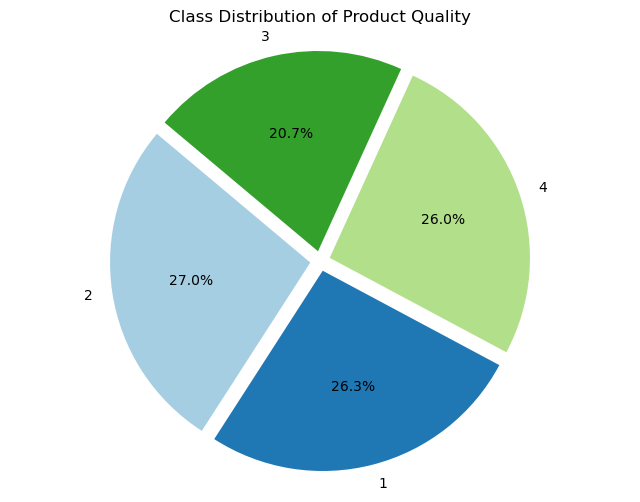

In [8]:
# Count occurrences of each quality class
class_counts = data['quality'].value_counts()

# Plot pie chart
plt.figure(figsize=(8, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', 
        colors=plt.cm.Paired.colors, startangle=140, explode=[0.05]*len(class_counts))

plt.title("Class Distribution of Product Quality")
plt.axis('equal')  # Ensures pie chart is circular
plt.show()

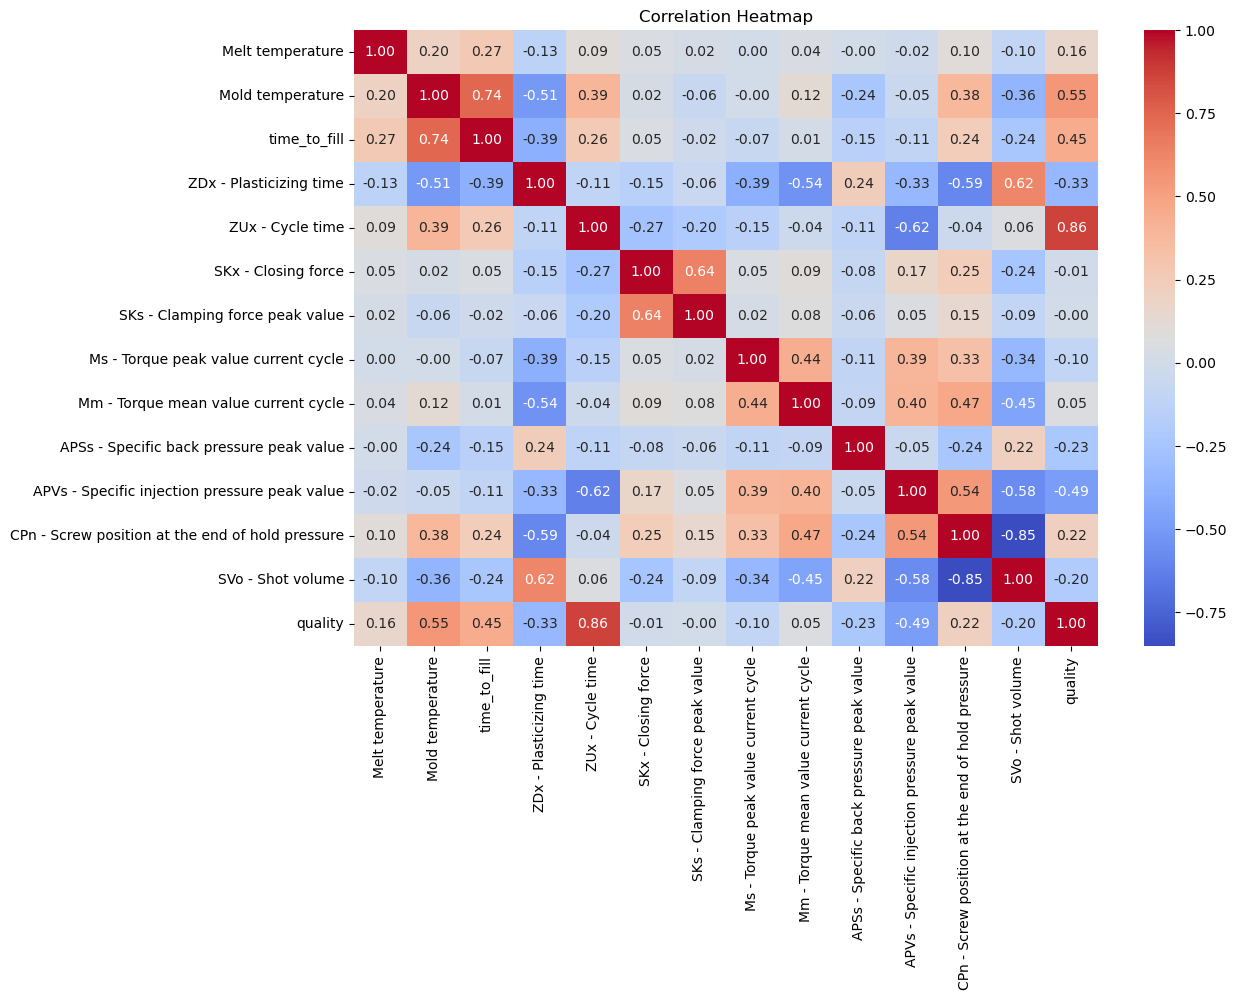

In [9]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Task 2: Data Preparation and Analysis

In [10]:
# Handling outliers using Z-score method
z_scores = np.abs((data - data.mean()) / data.std())
data_cleaned = data[(z_scores < 3).all(axis=1)]

In [11]:
# Data Preprocessing
X = data_cleaned.drop(columns=['quality'])
y = data_cleaned['quality']
# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print("\nData preprocessing complete. Train/Test split done.")



Data preprocessing complete. Train/Test split done.


In [12]:
# ANOVA Test to validate relationships between process parameters and product quality
anova_results = {}
for idx, column in enumerate(X.columns):
    groups = [X_train[y_train == cls, idx] for cls in np.unique(y_train)]
    stat, p_value = f_oneway(*groups)
    anova_results[column] = {'F-statistic': stat, 'p-value': p_value}

anova_df = pd.DataFrame(anova_results).T
print("\nANOVA Results:")
print(anova_df)


ANOVA Results:
                                                  F-statistic        p-value
Melt temperature                                     4.033492   7.350734e-03
Mold temperature                                   221.408988  4.025446e-102
time_to_fill                                       128.604918   7.019183e-67
ZDx - Plasticizing time                            178.054380   1.266179e-86
ZUx - Cycle time                                  6023.963376   0.000000e+00
SKx - Closing force                                 85.093723   3.205092e-47
SKs - Clamping force peak value                     51.598707   2.974058e-30
Ms - Torque peak value current cycle                 0.594305   6.188687e-01
Mm - Torque mean value current cycle                 0.812147   4.873277e-01
APSs - Specific back pressure peak value            28.595443   1.727354e-17
APVs - Specific injection pressure peak value      190.463825   3.235979e-91
CPn - Screw position at the end of hold pressure   129.46368

In [13]:
# Mood’s Median Test: Comparing Cycle Time Distribution Across High and Low-Quality Groups
from scipy.stats import median_test
# Define high and low-quality groups
data["quality_group"] = data["quality"].apply(lambda x: "High" if x >= 3 else "Low")

# Extract cycle time data for each group
high_quality = data[data["quality_group"] == "High"]["ZUx - Cycle time"]
low_quality = data[data["quality_group"] == "Low"]["ZUx - Cycle time"]

# Perform Mood’s Median Test
stat, p, med, tbl = median_test(high_quality, low_quality)

# Display results
print(f"Mood's Median Test Statistic: {stat}")
print(f"P-value: {p}")
print(f"Overall Median: {med}")

if p < 0.05:
    print("Significant difference between high and low-quality groups.")
else:
    print("No significant difference between high and low-quality groups.")

Mood's Median Test Statistic: 949.0849350329461
P-value: 2.097278267916736e-208
Overall Median: 74.83
Significant difference between high and low-quality groups.


# Task 3: Model Development

In [14]:
# K-Fold Cross Validation (k = 5 as an example)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [15]:
# Function to evaluate model performance
def evaluate_model(model):
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    return accuracy, f1, precision, recall, report, cm

# Random Forest Model

In [16]:
# Random Forest Model
print("\nTraining Random Forest Model")
rf_model = RandomForestClassifier(random_state=42)
rf_results = evaluate_model(rf_model)

# Hyperparameter Tuning for Random Forest
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
gs_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy')
gs_rf.fit(X_train, y_train)
best_rf_model = gs_rf.best_estimator_
best_rf_results = evaluate_model(best_rf_model)

# Display Results
print("\nRandom Forest Results")
print(f"Best Parameters: {gs_rf.best_params_}")
print(f"Accuracy: {best_rf_results[0]:.4f}")
print(f"F1 Score: {best_rf_results[1]:.4f}")
print(f"Precision: {best_rf_results[2]:.4f}")
print(f"Recall: {best_rf_results[3]:.4f}")
print("Classification Report:")
print(best_rf_results[4])
print("Confusion Matrix:")
print(best_rf_results[5])


Training Random Forest Model

Random Forest Results
Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.9674
F1 Score: 0.9672
Precision: 0.9684
Recall: 0.9674
Classification Report:
              precision    recall  f1-score   support

           1       0.96      0.98      0.97        49
           2       0.98      0.96      0.97        53
           3       1.00      0.91      0.95        32
           4       0.94      1.00      0.97        50

    accuracy                           0.97       184
   macro avg       0.97      0.96      0.97       184
weighted avg       0.97      0.97      0.97       184

Confusion Matrix:
[[48  1  0  0]
 [ 2 51  0  0]
 [ 0  0 29  3]
 [ 0  0  0 50]]


# Logistic Regression Model

In [17]:
# Logistic Regression
print("\nTraining Logistic Regression Model")
log_reg = LogisticRegression()
log_results = evaluate_model(log_reg)

# Hyperparameter Tuning for Logistic Regression
param_grid_lr = {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}
gs_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=5, scoring='accuracy')
gs_lr.fit(X_train, y_train)
best_lr_model = gs_lr.best_estimator_
best_lr_results = evaluate_model(best_lr_model)

# Display Results
print("\nLogistic Regression Results")
print(f"Best Parameters: {gs_lr.best_params_}")
print(f"Accuracy: {best_lr_results[0]:.4f}")
print(f"F1 Score: {best_lr_results[1]:.4f}")
print(f"Precision: {best_lr_results[2]:.4f}")
print(f"Recall: {best_lr_results[3]:.4f}")
print("Classification Report:")
print(best_lr_results[4])
print("Confusion Matrix:")
print(best_lr_results[5])



Training Logistic Regression Model

Logistic Regression Results
Best Parameters: {'C': 10, 'solver': 'lbfgs'}
Accuracy: 0.8913
F1 Score: 0.8907
Precision: 0.8937
Recall: 0.8913
Classification Report:
              precision    recall  f1-score   support

           1       0.86      0.78      0.82        49
           2       0.81      0.89      0.85        53
           3       1.00      0.91      0.95        32
           4       0.94      1.00      0.97        50

    accuracy                           0.89       184
   macro avg       0.90      0.89      0.90       184
weighted avg       0.89      0.89      0.89       184

Confusion Matrix:
[[38 11  0  0]
 [ 6 47  0  0]
 [ 0  0 29  3]
 [ 0  0  0 50]]


# Multi-Layer Perceptron (MLP)

In [18]:
# Multi-Layer Perceptron (MLP)
print("\nTraining MLP Model")
mlp_model = MLPClassifier(random_state=42)
mlp_results = evaluate_model(mlp_model)

# Hyperparameter Tuning for MLP
param_grid_mlp = {'hidden_layer_sizes': [(50,), (100,), (100,50)], 'activation': ['relu', 'tanh'], 'solver': ['adam', 'sgd']}
gs_mlp = GridSearchCV(MLPClassifier(random_state=42), param_grid_mlp, cv=5, scoring='accuracy')
gs_mlp.fit(X_train, y_train)
best_mlp_model = gs_mlp.best_estimator_
best_mlp_results = evaluate_model(best_mlp_model)

# Display Results
print("\nMLP Results")
print(f"Best Parameters: {gs_mlp.best_params_}")
print(f"Accuracy: {best_mlp_results[0]:.4f}")
print(f"F1 Score: {best_mlp_results[1]:.4f}")
print(f"Precision: {best_mlp_results[2]:.4f}")
print(f"Recall: {best_mlp_results[3]:.4f}")
print("Classification Report:")
print(best_mlp_results[4])
print("Confusion Matrix:")
print(best_mlp_results[5])



Training MLP Model

MLP Results
Best Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 50), 'solver': 'adam'}
Accuracy: 0.9457
F1 Score: 0.9456
Precision: 0.9457
Recall: 0.9457
Classification Report:
              precision    recall  f1-score   support

           1       0.94      0.96      0.95        49
           2       0.96      0.94      0.95        53
           3       0.94      0.91      0.92        32
           4       0.94      0.96      0.95        50

    accuracy                           0.95       184
   macro avg       0.94      0.94      0.94       184
weighted avg       0.95      0.95      0.95       184

Confusion Matrix:
[[47  2  0  0]
 [ 3 50  0  0]
 [ 0  0 29  3]
 [ 0  0  2 48]]


## LightGBM

In [19]:
# LightGBM
print("\nTraining LightGBM Model")
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_results = evaluate_model(lgb_model)

# Hyperparameter Tuning for LightGBM
param_grid_lgb = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [-1, 10, 20]}
gs_lgb = GridSearchCV(lgb.LGBMClassifier(random_state=42), param_grid_lgb, cv=5, scoring='accuracy')
gs_lgb.fit(X_train, y_train)
best_lgb_model = gs_lgb.best_estimator_
best_lgb_results = evaluate_model(best_lgb_model)

# Display Results
print("\nLightGBM Results")
print(f"Best Parameters: {gs_lgb.best_params_}")
print(f"Accuracy: {best_lgb_results[0]:.4f}")
print(f"F1 Score: {best_lgb_results[1]:.4f}")
print(f"Precision: {best_lgb_results[2]:.4f}")
print(f"Recall: {best_lgb_results[3]:.4f}")
print("Classification Report:")
print(best_lgb_results[4])
print("Confusion Matrix:")
print(best_lgb_results[5])



Training LightGBM Model
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1174
[LightGBM] [Info] Number of data points in the train set: 587, number of used features: 13
[LightGBM] [Info] Start training from score -1.344587
[LightGBM] [Info] Start training from score -1.239226
[LightGBM] [Info] Start training from score -1.665495
[LightGBM] [Info] Start training from score -1.344587
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

# CatBoost

In [20]:
# CatBoost
print("\nTraining CatBoost Model")
cat_model = cb.CatBoostClassifier(verbose=0, random_state=42)
cat_results = evaluate_model(cat_model)

# Hyperparameter Tuning for CatBoost
param_grid_cb = {'iterations': [100, 200], 'learning_rate': [0.01, 0.1], 'depth': [6, 10]}
gs_cb = GridSearchCV(cb.CatBoostClassifier(verbose=0, random_state=42), param_grid_cb, cv=5, scoring='accuracy')
gs_cb.fit(X_train, y_train)
best_cb_model = gs_cb.best_estimator_
best_cb_results = evaluate_model(best_cb_model)

# Display Results
print("\nCatBoost Results")
print(f"Best Parameters: {gs_cb.best_params_}")
print(f"Accuracy: {best_cb_results[0]:.4f}")
print(f"F1 Score: {best_cb_results[1]:.4f}")
print(f"Precision: {best_cb_results[2]:.4f}")
print(f"Recall: {best_cb_results[3]:.4f}")
print("Classification Report:")
print(best_cb_results[4])
print("Confusion Matrix:")
print(best_cb_results[5])


Training CatBoost Model

CatBoost Results
Best Parameters: {'depth': 10, 'iterations': 200, 'learning_rate': 0.1}
Accuracy: 0.9674
F1 Score: 0.9672
Precision: 0.9684
Recall: 0.9674
Classification Report:
              precision    recall  f1-score   support

           1       0.98      0.96      0.97        49
           2       0.96      0.98      0.97        53
           3       1.00      0.91      0.95        32
           4       0.94      1.00      0.97        50

    accuracy                           0.97       184
   macro avg       0.97      0.96      0.97       184
weighted avg       0.97      0.97      0.97       184

Confusion Matrix:
[[47  2  0  0]
 [ 1 52  0  0]
 [ 0  0 29  3]
 [ 0  0  0 50]]


# Task 4: Model Evaluation and Comparison

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1174
[LightGBM] [Info] Number of data points in the train set: 587, number of used features: 13
[LightGBM] [Info] Start training from score -1.344587
[LightGBM] [Info] Start training from score -1.239226
[LightGBM] [Info] Start training from score -1.665495
[LightGBM] [Info] Start training from score -1.344587
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

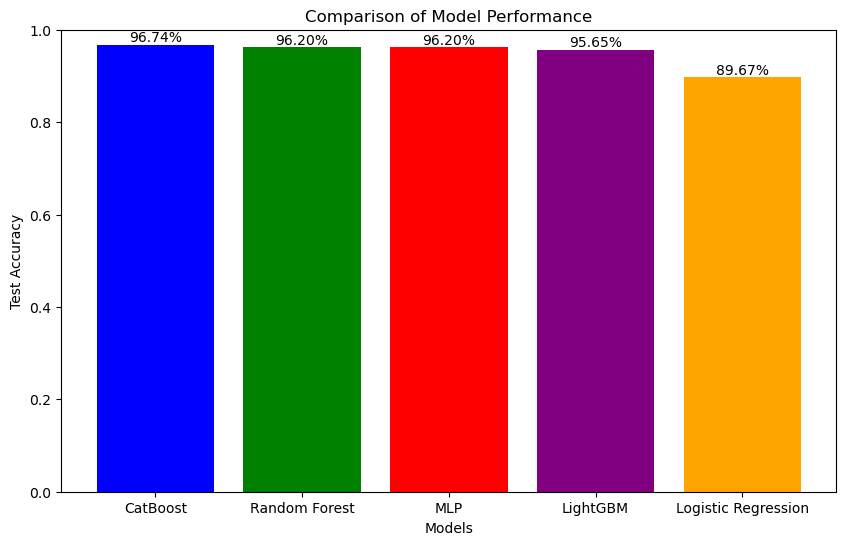

In [21]:

# Function to evaluate model performance
def evaluate_model(model):
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test, average='weighted')
    precision = precision_score(y_test, y_pred_test, average='weighted')
    recall = recall_score(y_test, y_pred_test, average='weighted')
    report = classification_report(y_test, y_pred_test)
    cm = confusion_matrix(y_test, y_pred_test)
    
    return train_accuracy, test_accuracy, f1, precision, recall, report, cm

# Model Results Dictionary
results = {}

# Random Forest Model
rf_model = RandomForestClassifier(random_state=42)
rf_results = evaluate_model(rf_model)
results['Random Forest'] = {'train_accuracy': rf_results[0], 'test_accuracy': rf_results[1], 'report': rf_results[5], 'cm': rf_results[6]}

# Multi-Layer Perceptron (MLP) Model
mlp_model = MLPClassifier(random_state=42, max_iter=500)
mlp_results = evaluate_model(mlp_model)
results['MLP'] = {'train_accuracy': mlp_results[0], 'test_accuracy': mlp_results[1], 'report': mlp_results[5], 'cm': mlp_results[6]}

# Logistic Regression Model
lr_model = LogisticRegression(random_state=42, max_iter=500)
lr_results = evaluate_model(lr_model)
results['Logistic Regression'] = {'train_accuracy': lr_results[0], 'test_accuracy': lr_results[1], 'report': lr_results[5], 'cm': lr_results[6]}

# LightGBM Model
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_results = evaluate_model(lgb_model)
results['LightGBM'] = {'train_accuracy': lgb_results[0], 'test_accuracy': lgb_results[1], 'report': lgb_results[5], 'cm': lgb_results[6]}

# CatBoost Model
cb_model = cb.CatBoostClassifier(random_state=42, verbose=0)
cb_results = evaluate_model(cb_model)
results['CatBoost'] = {'train_accuracy': cb_results[0], 'test_accuracy': cb_results[1], 'report': cb_results[5], 'cm': cb_results[6]}

# Model Comparison
comparison_df = pd.DataFrame({
    'Model': results.keys(),
    'Train Accuracy': [results[m]['train_accuracy'] for m in results],
    'Test Accuracy': [results[m]['test_accuracy'] for m in results],
})
comparison_df = comparison_df.sort_values(by='Test Accuracy', ascending=False)

# Visualization
plt.figure(figsize=(10,6))
bars = plt.bar(comparison_df['Model'], comparison_df['Test Accuracy'], color=['blue', 'green', 'red', 'purple', 'orange'])
plt.xlabel("Models")
plt.ylabel("Test Accuracy")
plt.title("Comparison of Model Performance")
plt.ylim(0, 1)

# Add accuracy labels on bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height()*100:.2f}%', ha='center', va='bottom')

plt.show()

# Best Model Selection
best_model_name = comparison_df.iloc[0]['Model']
best_model = {
    'Random Forest': rf_model,
    'MLP': mlp_model,
    'Logistic Regression': lr_model,
    'LightGBM': lgb_model,
    'CatBoost': cb_model
}[best_model_name]


In [22]:
import pickle

# Save the best model to a .pkl file
with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print(f"Best model ({best_model_name}) saved as 'best_model.pkl'.")


Best model (CatBoost) saved as 'best_model.pkl'.


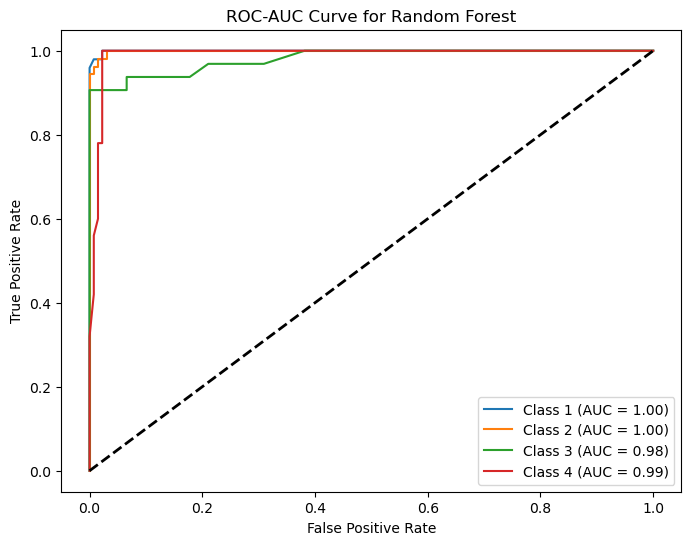

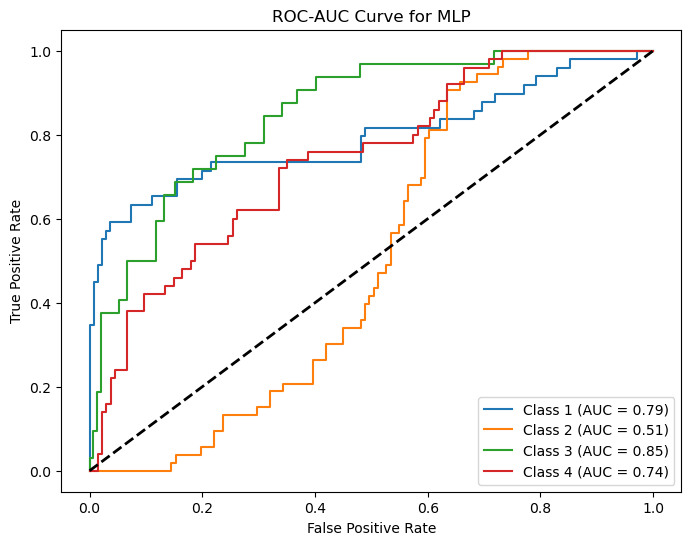

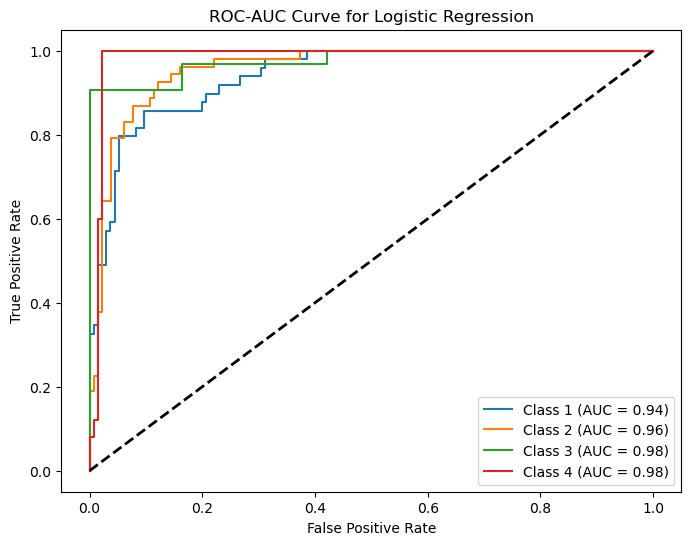

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 192, number of negative: 542
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1475
[LightGBM] [Info] Number of data points in the train set: 734, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.261580 -> initscore=-1.037771
[LightGBM] [Info] Start training from score -1.037771
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

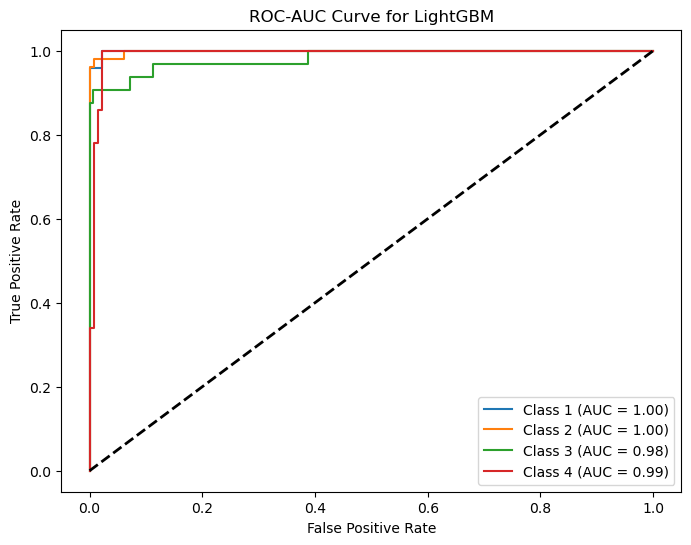

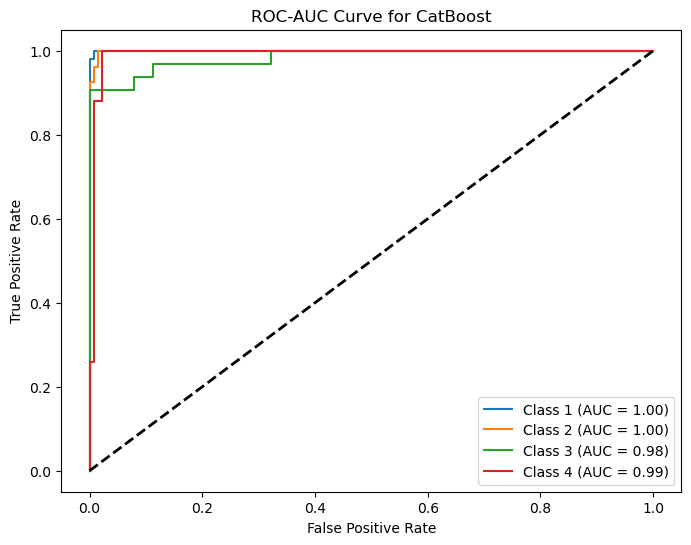

In [23]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
# Binarize labels for multi-class classification
classes = np.unique(y)
y_bin = label_binarize(y, classes=classes)  # Converts labels to one-hot encoded format
n_classes = y_bin.shape[1]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)

# Initialize models
models = {
    "Random Forest": OneVsRestClassifier(RandomForestClassifier(random_state=42)),
    "MLP": OneVsRestClassifier(MLPClassifier(random_state=42, max_iter=500)),
    "Logistic Regression": OneVsRestClassifier(LogisticRegression(random_state=42, max_iter=500)),
    "LightGBM": OneVsRestClassifier(lgb.LGBMClassifier(random_state=42)),
    "CatBoost": OneVsRestClassifier(cb.CatBoostClassifier(random_state=42, verbose=0))
}

# Generate individual ROC-AUC plots for each model
for name, model in models.items():
    model.fit(X_train, y_train)  # Train the model
    y_score = model.predict_proba(X_test)  # Get probability scores

    plt.figure(figsize=(8, 6))  # Create a new figure for each model

    # Compute and plot ROC curve for each class
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {classes[i]} (AUC = {roc_auc:.2f})")

    # Plot diagonal line (baseline)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC-AUC Curve for {name}")
    plt.legend(loc="lower right")

    # Show plot
    plt.show()

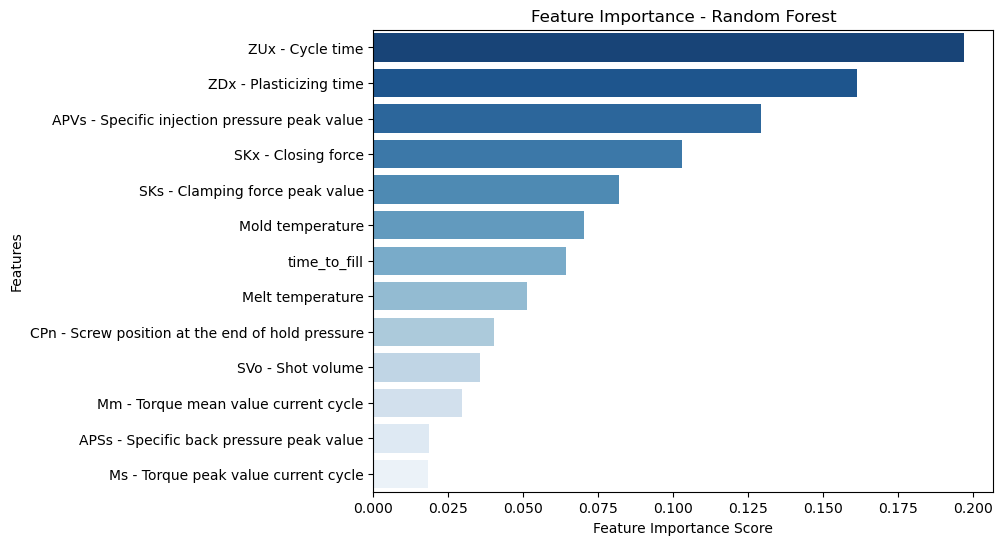

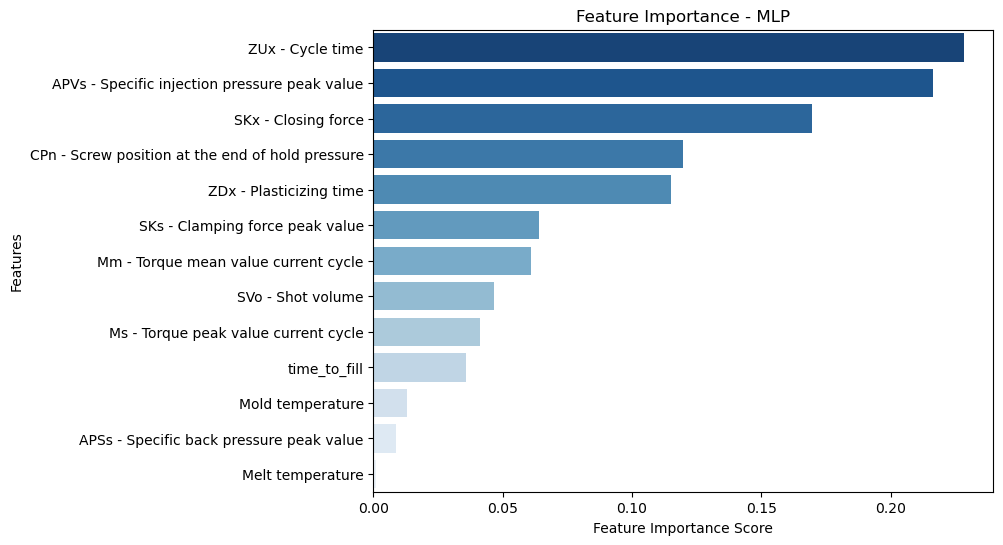

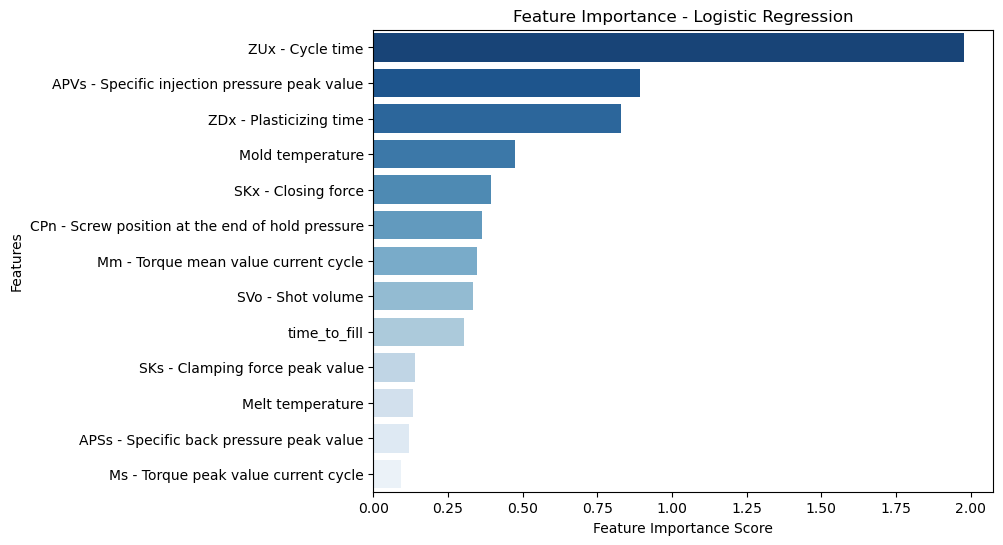

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1433
[LightGBM] [Info] Number of data points in the train set: 734, number of used features: 13
[LightGBM] [Info] Start training from score -1.341014
[LightGBM] [Info] Start training from score -1.251401
[LightGBM] [Info] Start training from score -1.656867
[LightGBM] [Info] Start training from score -1.341014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

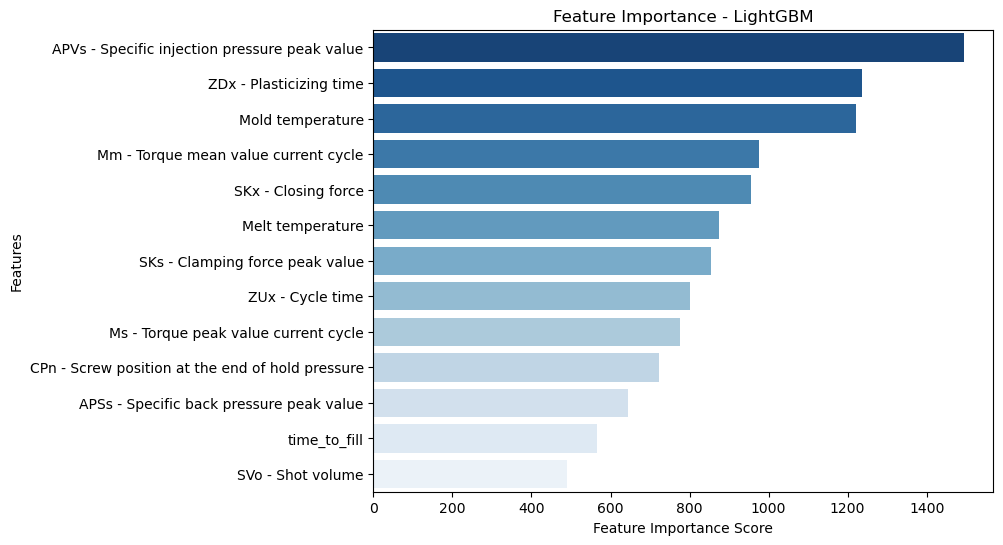

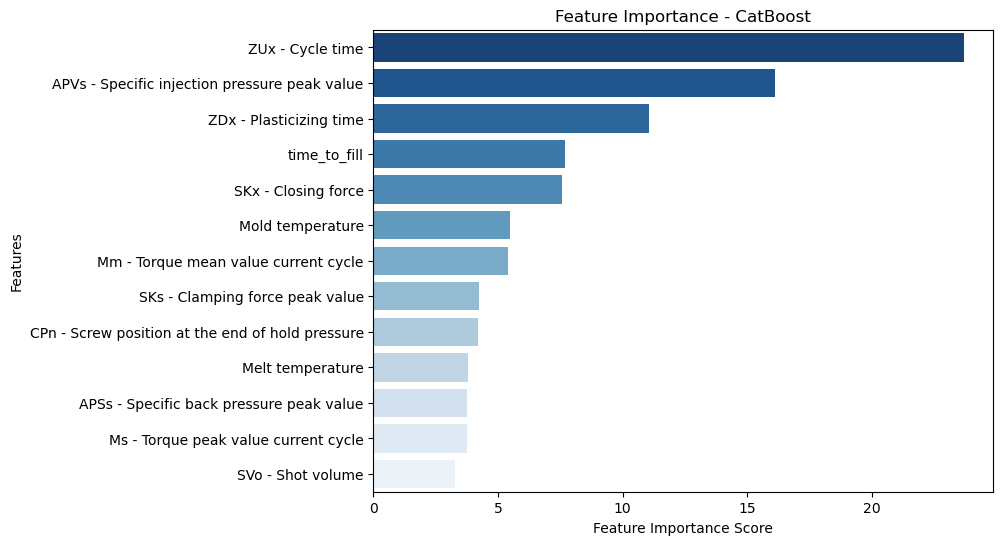

In [24]:
from sklearn.inspection import permutation_importance
feature_names = data.drop(columns=['quality']).columns  # Store feature names

# Ensure y is 1D (convert from one-hot if necessary)
if len(y.shape) > 1 and y.shape[1] > 1:
    y = np.argmax(y, axis=1)  # Convert from one-hot to categorical labels

# Standardize data for models requiring scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "MLP": MLPClassifier(random_state=42, max_iter=500),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=500),
    "LightGBM": lgb.LGBMClassifier(random_state=42),
    "CatBoost": cb.CatBoostClassifier(random_state=42, verbose=0)
}

# Generate Feature Importance plots
for name, model in models.items():
    model.fit(X_train, y_train)  # Train the model

    if hasattr(model, "feature_importances_"):  # Tree-based models
        importance = model.feature_importances_
    elif hasattr(model, "coef_"):
        importance = np.abs(model.coef_).mean(axis=0)  # Logistic Regression feature importance
    else:
        # Use permutation importance for models that don’t have feature_importances_
        perm_importance = permutation_importance(model, X_test, y_test, scoring='accuracy')
        importance = perm_importance.importances_mean  # Mean importance across iterations

    # Sort features by importance
    sorted_idx = np.argsort(importance)[::-1]

    # Plot Feature Importance
    plt.figure(figsize=(8, 6))
    sns.barplot(x=importance[sorted_idx], y=np.array(feature_names)[sorted_idx], palette="Blues_r")
    plt.xlabel("Feature Importance Score")
    plt.ylabel("Features")
    plt.title(f"Feature Importance - {name}")
    plt.show()

# Task 5. Develop an interactive dashboard

In [25]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import io
import base64
import scipy.stats as stats

# Load dataset
data = pd.read_csv('CW_Dataset_4125536.csv')
label_encoders = {}
categorical_columns = data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

feature_columns = data.drop(columns=['quality']).columns
scaler = StandardScaler()
df_scaled = scaler.fit_transform(data.drop(columns=['quality']))

# Load best model
with open('best_model.pkl', 'rb') as model_file:
    best_model = pickle.load(model_file)

# Initialize Dash app
app = dash.Dash(__name__)
app.layout = html.Div([
    html.H1("Product Quality Prediction Dashboard", style={'textAlign': 'center', 'color': '#2c3e50'}),
    
    html.Div([
        html.Div([
            html.H3("Enter Process Parameters:", style={'color': '#34495e'}),
            *[html.Div([html.Label(col, style={'fontWeight': 'bold'}), 
                        dcc.Input(id=col, type='number', value=0, style={'marginBottom': '10px'})]) 
              for col in feature_columns],
            html.Button("Predict", id='predict-button', n_clicks=0, style={'marginTop': '10px', 'backgroundColor': '#2980b9', 'color': 'white', 'padding': '10px'})
        ], style={'flex': '1', 'padding': '20px'}),
        
        html.Div([
            html.H3("Best Model Used:", style={'color': '#34495e'}),
            html.Pre(id='best-model-output', style={'border': '1px solid #bdc3c7', 'padding': '10px'}),
            html.H3("Prediction:", style={'color': '#34495e'}),
            html.Div(id='prediction-output', style={'fontSize': '20px', 'fontWeight': 'bold', 'color': '#16a085'})
        ], style={'flex': '1', 'padding': '20px'})
    ], style={'display': 'flex'}),
    
    html.Div([
        html.Div([
            html.H3("Confusion Matrix:", style={'color': '#34495e'}),
            html.Img(id='confusion-matrix-img', style={'width': '100%'})
        ], style={'flex': '1', 'padding': '20px'}),
        
        html.Div([
            html.H3("Feature Importance:", style={'color': '#34495e'}),
            dcc.Graph(id='feature-importance-graph')
        ], style={'flex': '1', 'padding': '20px'})
    ], style={'display': 'flex'}),
    
    html.Div([
        html.H3("Overall Production Quality", style={'color': '#34495e'}),
        dcc.Graph(id='quality-distribution')
    ], style={'padding': '20px'}),
    
    html.Div([
        html.H3("Product Scrap Rate", style={'color': '#34495e'}),
        dcc.Graph(id='scrap-rate')
    ], style={'padding': '20px'}),
    
    html.Div([
        html.H3("ANOVA Analysis", style={'color': '#34495e'}),
        dcc.Graph(id='anova-plot')
    ], style={'padding': '20px'}),
    
    html.H3("Classification Report:", style={'color': '#34495e', 'marginTop': '20px'}),
    html.Pre(id='classification-report', style={'border': '1px solid #bdc3c7', 'padding': '10px'})
], style={'fontFamily': 'Arial', 'maxWidth': '1200px', 'margin': 'auto'})

@app.callback(
    [Output('prediction-output', 'children'),
     Output('confusion-matrix-img', 'src'),
     Output('feature-importance-graph', 'figure'),
     Output('classification-report', 'children'),
     Output('best-model-output', 'children'),
     Output('quality-distribution', 'figure'),
     Output('scrap-rate', 'figure'),
     Output('anova-plot', 'figure')],
    [Input('predict-button', 'n_clicks')],
    [Input(col, 'value') for col in feature_columns]
)
def update_dashboard(n_clicks, *values):
    if n_clicks > 0:
        try:
            input_data = pd.DataFrame([values], columns=feature_columns)
            input_scaled = scaler.transform(input_data)
            prediction = best_model.predict(input_scaled)[0]
            
            # Confusion Matrix
            y_pred = best_model.predict(df_scaled)
            cm = confusion_matrix(data['quality'], y_pred)
            fig, ax = plt.subplots()
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
            buf = io.BytesIO()
            plt.savefig(buf, format="png")
            plt.close(fig)
            buf.seek(0)
            encoded_image = base64.b64encode(buf.read()).decode('utf-8')
            cm_src = f'data:image/png;base64,{encoded_image}'
            
            # Feature Importance
            feature_importance = best_model.feature_importances_
            fig_feature = px.bar(x=feature_columns, y=feature_importance, title="Feature Importance")
            
            # Classification Report
            class_report = classification_report(data['quality'], y_pred)
            
            # Quality Distribution
            fig_quality = px.histogram(data, x='quality', title="Quality Distribution")
            
            # Scrap Rate
            scrap_rate = (data['quality'] == 0).sum() / len(data)
            fig_scrap = px.pie(names=['Scrapped', 'Good'], values=[scrap_rate, 1 - scrap_rate], title="Product Scrap Rate")
            
            # ANOVA Analysis
            anova_result = stats.f_oneway(*[data[data['quality'] == q][feature_columns[0]] for q in data['quality'].unique()])
            fig_anova = px.bar(x=['F-statistic', 'p-value'], y=[anova_result.statistic, anova_result.pvalue], title="ANOVA Results")
            
            return f'Predicted Quality: {prediction}', cm_src, fig_feature, class_report, str(best_model), fig_quality, fig_scrap, fig_anova
        except Exception as e:
            return f'Error: {str(e)}', '', {}, '', '', {}, {}, {}
    return "", "", {}, "", "", {}, {}, {}

if __name__ == '__main__':
    app.run(debug=True)
